### Imports

In [12]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [13]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [14]:
experiment_name = 'Saccharose hydrolysis'

In [15]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_hydrolysis/preprocessed_mixture.csv',
                'PMG 284 monitoring': '../data/PMG_284/preprocessed_mixture.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture_cut_to_regions.csv'
                }

###########################
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_hydrolysis/all_ref_align_14_10_2024.csv',
                'PMG 284 monitoring': '../data/PMG_284/preprocessed_mixture.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture_cut_to_regions.csv'
                }
###########################

reagents_paths = {'Saccharose hydrolysis': ['../data/saccharose_hydrolysis/preprocessed_saccharose.csv', 
                                            '../data/saccharose_hydrolysis/preprocessed_alpha_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_beta_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_fructose.csv'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_pentene.csv',
                                      '../data/PMG_284/preprocessed_triethylsilane.csv',
                                      '../data/PMG_284/preprocessed_product.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_hexene.csv',
                                      '../data/PMG_287/preprocessed_triethylsilane.csv',
                                      '../data/PMG_287/preprocessed_product.csv']}

mixture_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

reagents_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

results_paths = {'Saccharose hydrolysis': '../results/saccharose_hydrolysis/',
                'PMG 284 monitoring': '../results/PMG_284/',
                'PMG 287 monitoring': '../results/PMG_287/cut_spectrum_of_mixture/'}

#### Mixture in time

In [16]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    #########################################################
    ppm = mixture_time_data.iloc[1:,0:1]
    ints = mixture_time_data.iloc[1:,1:]
    mixture_time_data.astype(float)
    mixture_time_data.fillna(0, inplace=True)
    every_10th = mixture_time_data = mixture_time_data.iloc[:,1:].iloc[:,::10]
    #########################################################
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [17]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [18]:
mixture_time_data.columns = names

In [20]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.trim_negative_intensities()
    sp.normalize()
    return sp

#### Reagents

In [21]:
reagents_spectra = []
for reagent in reagents_paths[experiment_name]:
    reag = pd.read_csv(reagent, sep=reagents_separators[experiment_name], header=None).iloc[:,:2]
    reagents_spectra.append(reag)

In [22]:
reagents_spectra2 = []
for reag in reagents_spectra:
    ppm = reag.iloc[:,0]
    ints = reag.iloc[:,1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    reagents_spectra2.append(sp)
reagents_spectra = reagents_spectra2
del(reagents_spectra2)

In [23]:
for sp in reagents_spectra:
    sp.trim_negative_intensities()
    sp.normalize()

In [24]:
%matplotlib notebook

In [25]:
reagents_spectra

<IPython.core.display.Javascript object>


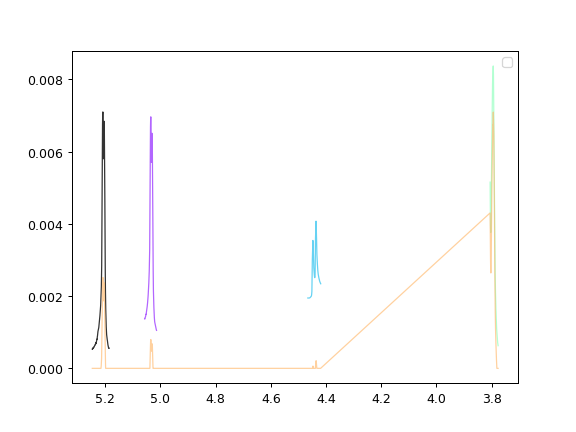

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [28]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all(reagents_spectra + [load_spectrum(mixture_time_data, 100)], profile=True)

### Estimation

In [33]:
kappa = 0.25
kappa_th = 0.25
#0.25, 0.5

In [34]:
proportions_in_times = []
noise_proportions_in_times = []
noise = []
noise_in_components = []

for i in range(1, mixture_time_data.shape[1]):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(mixture_time_data, i)
    mix.trim_negative_intensities()
    mix.normalize()
    estimation = estimate_proportions(mix, reagents_spectra, what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    noise.append(estimation['noise'])
    noise_in_components.append(estimation['noise_in_components'])
#     if i>1:
#         assert estimation['common_horizontal_axis'] == common_horizontal_axis
    common_horizontal_axis = estimation['common_horizontal_axis']
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

Proportions:

[0.21070994810944424, -0.0, 0.6289042410536485, 0.06444090971884618]


Proportion_of_noise_in_components:

0.005422755322717366


This is timepoint 2.

Proportions:

[0.21346658217866202, -0.0, 0.626327585750079, 0.06504034582600188]


Proportion_of_noise_in_components:

0.005343655995879203


This is timepoint 3.

Proportions:

[0.21450799404788154, -0.0, 0.6260249563578726, 0.06537068912330236]


Proportion_of_noise_in_components:

0.004994785757441423


This is timepoint 4.

Proportions:

[0.21427410453503634, -0.0, 0.6252972021275239, 0.06604270829666456]


Proportion_of_noise_in_components:

0.004924635255931959


This is timepoint 5.

Proportions:

[0.21489937816688628, -0.0, 0.6244646321035403, 0.06682990001229647]


Proportion_of_noise_in_components:

0.004743761048662481


This is timepoint 6.

Proportions:

[0.2149036643984554, -0.0, 0.6245993146707165, 0.0672879293922744]


Proportion_of_noise_in_components:

0.004543124257230456


This is

Proportions:

[0.18727785489415288, -0.0, 0.6471749193304315, 0.10342605557386919]


Proportion_of_noise_in_components:

0.0


This is timepoint 53.

Proportions:

[0.1872592324645305, -0.0, 0.6472582608655415, 0.10392960626325527]


Proportion_of_noise_in_components:

0.0


This is timepoint 54.

Proportions:

[0.18797127520896253, -0.0, 0.6458778471119361, 0.10487809227903266]


Proportion_of_noise_in_components:

0.0


This is timepoint 55.

Proportions:

[0.18662050854021842, -0.0, 0.6466498634868121, 0.10602895562180249]


Proportion_of_noise_in_components:

0.0


This is timepoint 56.

Proportions:

[0.1862044720107337, -0.0, 0.6470244476838629, 0.10649420852957339]


Proportion_of_noise_in_components:

0.0


This is timepoint 57.

Proportions:

[0.1864943425177544, -0.0, 0.6476181262750601, 0.10645120376954649]


Proportion_of_noise_in_components:

0.0


This is timepoint 58.

Proportions:

[0.18512136338638507, -0.0, 0.6482380768671844, 0.1076516565703836]


Proportion_of_noise

In [35]:
len(proportions_in_times)

103

<IPython.core.display.Javascript object>


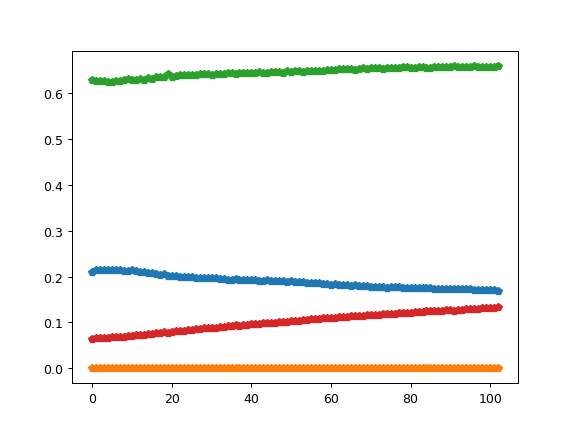

In [37]:
plt.plot(range(len(proportions_in_times)), [prop[0] for prop in proportions_in_times], 'p')
plt.plot(range(len(proportions_in_times)), [prop[1] for prop in proportions_in_times], 'p')
plt.plot(range(len(proportions_in_times)), [prop[2] for prop in proportions_in_times], 'p')
plt.plot(range(len(proportions_in_times)), [prop[3] for prop in proportions_in_times], 'p')

In [38]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(proportions_in_times, f)

In [39]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

In [40]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(common_horizontal_axis, f)

In [41]:
with open(results_paths[experiment_name]+'noise_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise, f)

In [42]:
with open(results_paths[experiment_name]+'noise_in_components_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_in_components, f)